# Setup

This notebook expands on the analysis of LLM text using linguistic features in [Reinhart et. al. (2025)](https://www.pnas.org/doi/epdf/10.1073/pnas.2422455122). Here, we attempt to replicate their experiments, doing further model selection to find the most relevant linguistic features.

## Environment and Dataset setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
# Loads data from HuggingFace: https://huggingface.co/datasets/browndw/human-ai-parallel-corpus-biber/discussions
import datasets
from datasets import load_dataset

data = load_dataset('browndw/human-ai-parallel-corpus-biber', split='train')

README.md:   0%|          | 0.00/645 [00:00<?, ?B/s]

biber_data/hape-biber_gpt-4o-2024-08-06.(…):   0%|          | 0.00/1.39M [00:00<?, ?B/s]

biber_data/hape-biber_gpt-4o-mini-2024-0(…):   0%|          | 0.00/1.60M [00:00<?, ?B/s]

biber_data/hape-biber_human-chunk-1.parq(…):   0%|          | 0.00/1.36M [00:00<?, ?B/s]

biber_data/hape-biber_human-chunk-2.parq(…):   0%|          | 0.00/1.38M [00:00<?, ?B/s]

biber_data/hape-biber_llama-3-70B-Instru(…):   0%|          | 0.00/1.80M [00:00<?, ?B/s]

biber_data/hape-biber_llama-3-70B.parque(…):   0%|          | 0.00/1.87M [00:00<?, ?B/s]

biber_data/hape-biber_llama-3-8B-Instruc(…):   0%|          | 0.00/1.76M [00:00<?, ?B/s]

biber_data/hape-biber_llama-3-8B.parquet:   0%|          | 0.00/1.89M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/66320 [00:00<?, ? examples/s]

In [3]:
# Plotting Utilities

# Sets up a nice theme for seaborn
sns.set_theme(style="darkgrid", palette="Set2", font="DejaVu Serif")

# Set up name mappings, colormaps
model_name_map = {
  "gpt-4o-2024-08-06":"GPT 4o",
  "gpt-4o-mini-2024-07-18":"GPT 4o Mini",
  "chunk_1": "Human 1",
  "chunk_2": "Human 2",
  "Meta-Llama-3-70B-Instruct": "Llama 3 70B Instruct",
  "Meta-Llama-3-70B": "Llama 3 70B",
  "Meta-Llama-3-8B-Instruct": "Llama 3 8B Instruct",
  "Meta-Llama-3-8B": "Llama 3 8B"
}

is_human_cmap = {
    True: "firebrick",
    False: "steelblue",
}

model_cmap = {
  "GPT 4o": "#10a37e",
  "GPT 4o Mini": "#77a69a",
  "Human 1": "#a35510",
  "Human 2": "#a35510",
  "Llama 3 70B Instruct":"#a3109e",
  "Llama 3 8B Instruct":"#a355a1",
  "Llama 3 70B":"#101aa3",
  "Llama 3 8B":"#454ba3"
}

bias_variance_cmap = {
    "train": sns.color_palette('Set2')[1],
    "test": sns.color_palette('Set2')[2],
    "cv": sns.color_palette('Set2')[3]
}

## Data Preprocessing


In [4]:
if type(data) != pd.DataFrame:
  data = data.to_pandas()
data

,doc_id,f_01_past_tense,f_02_perfect_aspect,f_03_present_tense,f_04_place_adverbials,f_05_time_adverbials,f_06_first_person_pronouns,f_07_second_person_pronouns,f_08_third_person_pronouns,f_09_pronoun_it,...,f_58_verb_seem,f_59_contractions,f_60_that_deletion,f_61_stranded_preposition,f_62_split_infinitive,f_63_split_auxiliary,f_64_phrasal_coordination,f_65_clausal_coordination,f_66_neg_synthetic,f_67_neg_analytic
0,acad_0001@gpt-4o-2024-08-06,0.000000,0.000000,57.377049,0.000000,0.000000,0.000000,0.000000,10.245902,6.147541,...,0.000000,0.000000,0.000000,0.000000,2.049180,10.245902,26.639344,6.147541,2.049180,10.245902
1,acad_0002@gpt-4o-2024-08-06,1.908397,3.816794,38.167939,5.725191,0.000000,0.000000,0.000000,1.908397,3.816794,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.816794,24.809160,0.000000,0.000000,3.816794
2,acad_0003@gpt-4o-2024-08-06,9.380863,1.876173,52.532833,0.000000,1.876173,16.885553,0.000000,3.752345,5.628518,...,1.876173,0.000000,0.000000,0.000000,0.000000,1.876173,7.504690,1.876173,0.000000,9.380863
3,acad_0004@gpt-4o-2024-08-06,2.150538,0.000000,34.408602,6.451613,0.000000,4.301075,0.000000,10.752688,0.000000,...,0.000000,0.000000,2.150538,0.000000,0.000000,6.451613,19.354839,0.000000,0.000000,0.000000
4,acad_0005@gpt-4o-2024-08-06,1.869159,1.869159,44.859813,3.738318,0.000000,3.738318,0.000000,7.476636,7.476636,...,0.000000,0.000000,0.000000,0.000000,1.869159,5.607477,24.299065,3.738318,0.000000,3.738318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66315,tvm_1095@Meta-Llama-3-8B,31.045752,9.803922,84.967320,1.633987,8.169935,62.091503,16.339869,40.849673,9.803922,...,0.000000,24.509804,0.000000,1.633987,0.000000,4.901961,0.000000,11.437908,1.633987,6.535948
66316,tvm_1096@Meta-Llama-3-8B,18.998273,1.727116,245.250432,1.727116,6.908463,212.435233,48.359240,22.452504,12.089810,...,0.000000,212.435233,1.727116,0.000000,0.000000,0.000000,1.727116,5.181347,3.454231,17.271157
66317,tvm_1097@Meta-Llama-3-8B,37.225042,1.692047,191.201354,5.076142,1.692047,184.433164,64.297800,10.152284,13.536379,...,0.000000,164.128596,1.692047,0.000000,0.000000,1.692047,0.000000,3.384095,0.000000,18.612521
66318,tvm_1098@Meta-Llama-3-8B,42.857143,3.571429,100.000000,7.142857,3.571429,32.142857,82.142857,50.000000,7.142857,...,0.000000,28.571429,0.000000,3.571429,0.000000,3.571429,0.000000,7.142857,3.571429,25.000000


In [5]:
# Extract models from filenames
def get_model(doc_id):
  try:
    return re.findall(r'\@(.+)', doc_id)[0]
  except Exception as e:
    print(doc_id)
    raise e

data['model'] = data['doc_id'].apply(get_model)
data['model'] = data['model'].apply(lambda x: model_name_map[x])
data['model'].value_counts()

,count
model,
GPT 4o,8290
GPT 4o Mini,8290
Human 1,8290
Human 2,8290
Llama 3 70B Instruct,8290
Llama 3 70B,8290
Llama 3 8B Instruct,8290
Llama 3 8B,8290


In [6]:
#engineer binary response
data['is_human'] = data['model'].isin(['Human 1', 'Human 2'])
data['is_human'].value_counts(normalize=True)

,proportion
is_human,
False,0.75
True,0.25


In [7]:
readable_features = pd.Series(data.columns).apply(lambda s: " ".join(s.split("_")[2:]))
readable_features.index = data.columns
readable_features = dict(readable_features[readable_features != ""].sort_values(ascending=True))
# readable_features

# Exploratory Data Analysis

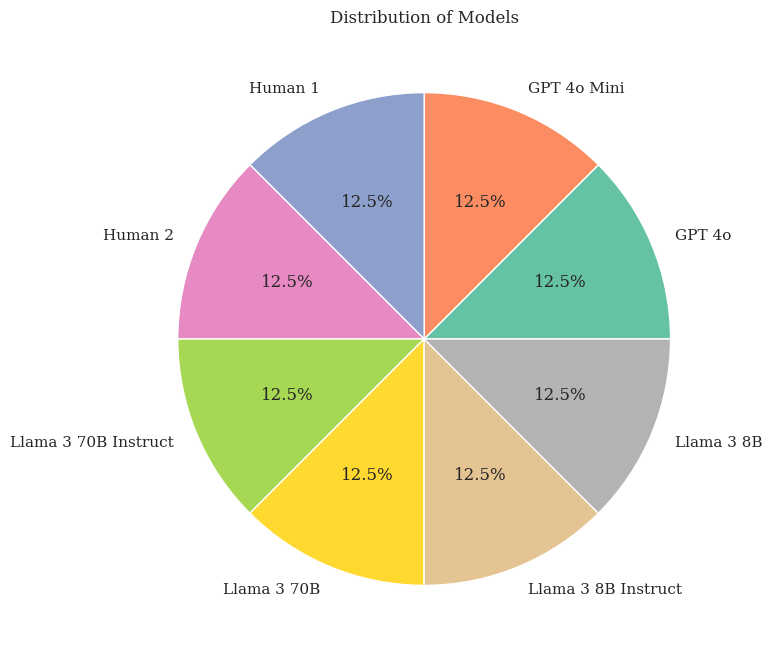

In [8]:
# Looking at model counts
model_counts = data['model'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(
    model_counts,
    labels=model_counts.index,
    autopct='%1.1f%%',
)
plt.title('Distribution of Models')
plt.show()

In [9]:
data['model'].value_counts()

,count
model,
GPT 4o,8290
GPT 4o Mini,8290
Human 1,8290
Human 2,8290
Llama 3 70B Instruct,8290
Llama 3 70B,8290
Llama 3 8B Instruct,8290
Llama 3 8B,8290


Models are evenly distributed, but that means there are far more model-generated texts than human-generated.

### Dataset Summary
Each feature in the dataset corresponds to a linguistic feature described in [Biber (1993)](https://aclanthology.org/J93-2001/). Since there are so many features, we can look at distributions of summary statistics to get a sense for scale.

In [10]:
data_summary = data.describe().T
data_summary

,count,mean,std,min,25%,50%,75%,max
f_01_past_tense,66320.0,39.202372,35.502852,0.0,7.389163,29.259897,66.552901,370.550162
f_02_perfect_aspect,66320.0,6.680611,6.931946,0.0,1.945525,4.966887,9.324009,215.619694
f_03_present_tense,66320.0,57.498366,40.072588,0.0,26.315789,52.884615,84.016393,479.099678
f_04_place_adverbials,66320.0,3.944512,4.128799,0.0,0.000000,3.100775,6.012024,166.071429
f_05_time_adverbials,66320.0,3.366265,5.535424,0.0,0.000000,2.183406,5.050505,750.617284
...,...,...,...,...,...,...,...,...
f_63_split_auxiliary,66320.0,3.381334,3.432652,0.0,0.000000,2.369668,4.977190,90.909091
f_64_phrasal_coordination,66320.0,8.362944,7.809598,0.0,3.115265,6.651885,11.904762,448.648649
f_65_clausal_coordination,66320.0,12.686895,11.078509,0.0,4.672897,10.115607,17.953321,198.019802
f_66_neg_synthetic,66320.0,0.861562,2.186873,0.0,0.000000,0.000000,1.610306,229.755179


In [ ]:
data_summary.mean(axis=0)

count    66320.000000
mean        13.457754
std         10.251392
min          0.016584
25%          6.833287
50%         11.324898
75%         18.018303
max        707.514165
dtype: float64

There are 66,320 entries in this dataset, split evenly amongst 6 LLMs and human generations. Most of the features have a heavily skewed-right distribution, with the maximum value, likely an outlier, being an order of magnitude higher than the mean.

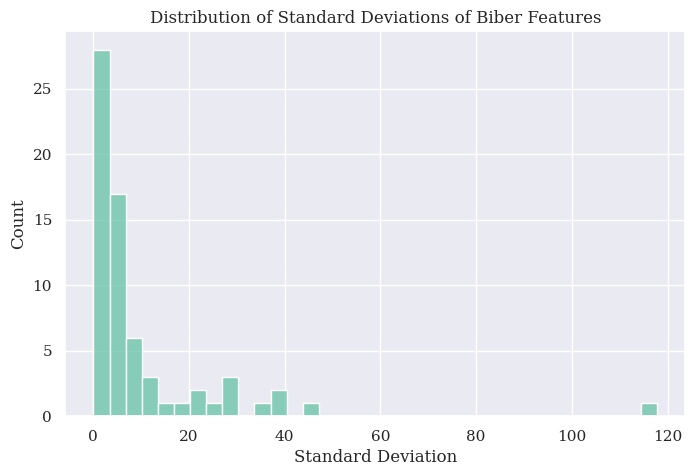

In [11]:
plt.subplots(figsize=(8, 5))
sns.histplot(data_summary["std"])
plt.xlabel("Standard Deviation")
plt.title("Distribution of Standard Deviations of Biber Features");

Most features have low variance across examples in general, with a few notable outliers.

In [12]:
print("Most varied features:")
top_5_variance = data_summary.sort_values(by="std", ascending=False)["std"][:5].index
for i, feature in enumerate(top_5_variance):
  print(f"- {i+1}: {readable_features[feature]}")

print("\nDifference in variance between LLM and Human:")
for i, feature in enumerate(top_5_variance):
  human_std = data.loc[data['is_human'] == True, feature].std()
  llm_std = data.loc[data['is_human'] == False, feature].std()
  print(f"- {i+1}: {readable_features[feature]}: {round(llm_std - human_std, 2)}")


Most varied features:
- 1: other nouns
- 2: prepositions
- 3: present tense
- 4: first person pronouns
- 5: past tense

Difference in variance between LLM and Human:
- 1: other nouns: 43.79
- 2: prepositions: 23.75
- 3: present tense: 8.74
- 4: first person pronouns: 7.89
- 5: past tense: 6.91


In general, these features seem more varied for LLMs than humans. This makes sense, since we're comparing many different LLM families and sizes, which could lead to very high variation in generation, despite there being much more LLM data than human data. Something poignant when forming our dataset would be to both subsample the LLM data so it matches the size of the human dataset, and also stratify by LLM family/type when doing this subsampling.

## Most Distinguishing Features
Reinhart et. al. (2025) list out the most distinguishing features in their 7-class classification task in their [appendix](https://www.pnas.org/doi/10.1073/pnas.2422455122#supplementary-materials). Here, we'll investigate these features and attempt to determine why they were so predictive of author class.

### Syntactic features: Present participle clauses, 'That' clauses as subject
The paper found that use of present participles clauses (e.g. "*Stuffing his face with cookies,* John rushed out the door") and 'That' relative clauses in the subject position (e.g. "The cookies *that John ate*") were both markedly higher than humans in instruction-tuned or RLHF tuned LLMs, while the base LLM had *lower* use.

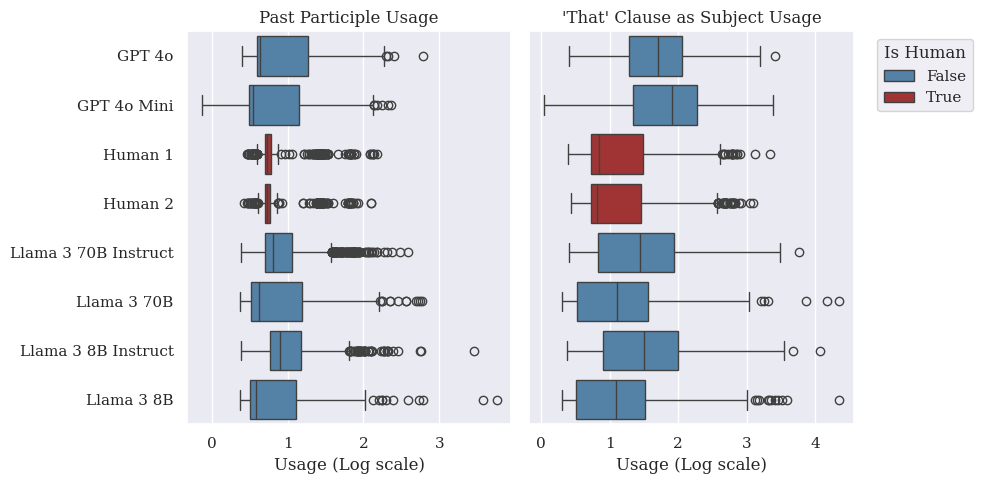

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.boxplot(data, y="model", x=np.log(data["f_26_past_participle"]), hue="is_human",
                 palette=is_human_cmap, ax=axes[0])
sns.boxplot(data, y="model", x=np.log(data["f_29_that_subj"]), hue="is_human",
                 palette=is_human_cmap, ax=axes[1])
axes[0].set_yticklabels(model_name_map.values())
axes[0].set_title("Past Participle Usage")
axes[1].set_title("'That' Clause as Subject Usage")
axes[0].set_ylabel("")
axes[0].set_xlabel("Usage (Log scale)")
axes[1].set_xlabel("Usage (Log scale)")
axes[0].legend().set_visible(False)
# move legend off of plots
plt.legend(title="Is Human", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout();


LLM usage of these features seems not only significantly higher, but much more varied than human usage.

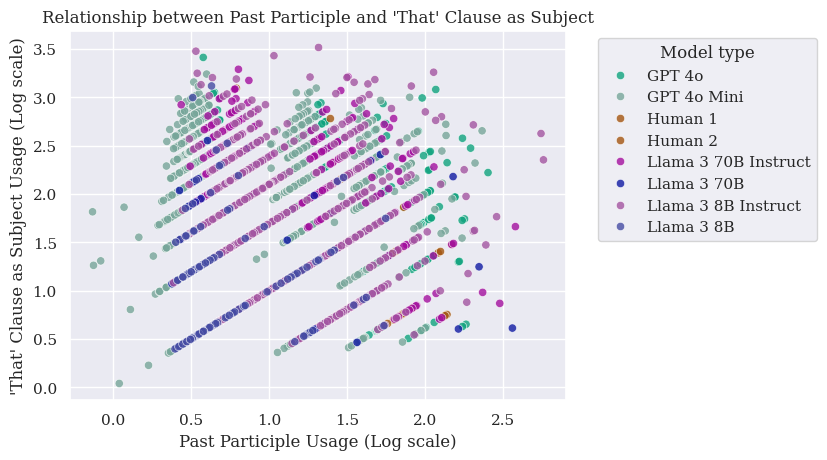

In [ ]:
sns.scatterplot(data, x=np.log(data['f_26_past_participle']), y=np.log(data['f_29_that_subj']),
                hue='model', palette=model_cmap, alpha=0.8)
plt.title("Relationship between Past Participle and 'That' Clause as Subject")
plt.legend(title="Model type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Past Participle Usage (Log scale)")
plt.ylabel("'That' Clause as Subject Usage (Log scale)");

On a log scale, these two features also seem strongly correlated within a few lines, indicating that one becomes predictable given some other feature (possibly text genre or length).

### Mean Word Length
The mean length of words in texts was found to be slightly higher in instruction-tuned LLMs, but about the same as humans in base LLMs. This makes sense, since base LLMs would generate text with more generalized distributions as humans, whereas instruction-tuned LLMs might have bias introduced by instruction datasets.

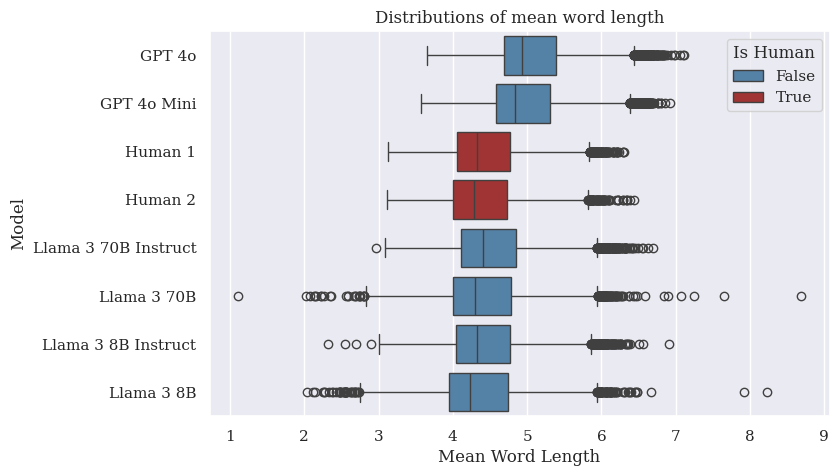

In [ ]:
fig, axes = plt.subplots(figsize=(8, 5), sharey=True)
ax = sns.boxplot(data, y="model", x=data['f_44_mean_word_length'], hue="is_human",
                 palette=is_human_cmap);
ax.set_yticklabels(model_name_map.values())
plt.title("Distributions of mean word length")
plt.ylabel("Model")
plt.xlabel("Mean Word Length")
plt.legend(title="Is Human");

For this feature, LLM distributions indeed seem to be closer to human distributions, and to each other. However, the paper still found this to be particularly predictive of author class in their RF models. This indicates that this could only be predictive as an interaction with another feature, or that the separation is not linear, meaning thie feature might not be effective in Logistic Regression models.

## Dimensionality Reduction with UMAP
We have a relatively high-dimensional dataset, which makes it hard to visualize. In this section, we'll use U-MAP to try and reduce the dimensionality and see how separable the data is.

In [ ]:
# import umap

# reducer = umap.UMAP(metric="cosine", random_state=109, )
# X2 = reducer.fit_transform(data.drop(columns=['doc_id', 'model', 'is_human']))
# X2 = pd.DataFrame(X2)

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# sns.scatterplot(X2[data['is_human']],x=0, y=1, color=is_human_cmap[True], ax=axes[0])
# sns.scatterplot(X2[~data['is_human']],x=0, y=1, color=is_human_cmap[False], ax=axes[1])
# plt.suptitle("UMAP Projection of Data")
# plt.legend(title="Is Human")
# plt.tight_layout();

In [ ]:
# sns.scatterplot(X2,x=0, y=1, hue=data['model'], palette=model_cmap, alpha=0.05)
# plt.legend(title='Model Type', bbox_to_anchor=(1, 1));


# Model Fitting
With the knowledge of our features, we can begin fitting model variants. For this task, we will fit models from two families. We will test performance on binary classification between LLM-generated or human-generated text.

The first model we will test is a Random Forest Classifier. We chose this based on the success of this model in the paper, as well as its general strength in capturing nonlinearities. For this model, we will try tuning the parameter space, hyperparameters such as n_trees and max_features, and finally trying different criterion for splitting.

The second model is a Logistic Regression. We chose this based on its simplicity and interpretability. For our logistic regression models, we will train three models on three different subsets of parameters, comparing performance across all three.

In [13]:
# Import model fitting libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
  f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# For reproduceability, use the seed 109
SEED=109
# Since our dataset is so large, we subsample for model fitting to reduce training time.
SUBSAMPLE_PROP = 0.01

In [14]:
# data preparation
response = 'is_human'
N_human = data['is_human'].sum()
#subsampled_data = data.groupby(response).sample(n=int(N_human * SUBSAMPLE_PROP), random_state=SEED)
subsampled_data = data #re-running with all data
X = subsampled_data.drop(columns=['doc_id', 'model', 'is_human'])
y = subsampled_data[response]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [15]:
y.value_counts()

,count
is_human,
False,49740
True,16580


## Random Forest Models

### RF Model Variant 1: Maximal Model
First, we'll fit a model on all of the data, then analyze feature importance to determine how to proceed. Later, we'll tune the features we use as well as the hyperparameters, but we can start with a default model for now. However, since RF models have a chance of not including all features, and we have a lot of features in our dataset, we'll increase the number of trees so all features are represented.

In [ ]:
rf_var_1 = RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1, max_depth=16) # Increase n_estimators
rf_var_1.fit(X_train, y_train)
importances = pd.Series(rf_var_1.feature_importances_, index=X_train.columns).sort_values(ascending=False)
maximal_model_acc = rf_var_1.score(X_test, y_test)
print(f"Maximal model accuracy: {maximal_model_acc}")

Maximal model accuracy: 0.9367460796139928


<Axes: title={'center': 'Feature Importance Contour'}, xlabel='Feature Index (ranked by importance)', ylabel='Importance'>

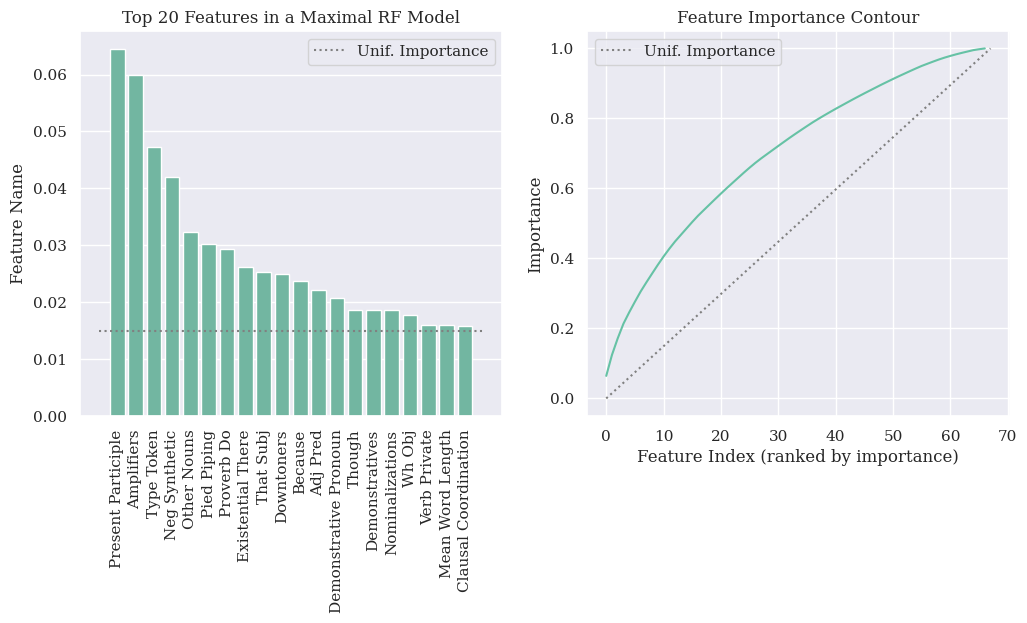

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=importances.index[:20], y=importances.head(20), ax=axes[0])
axes[0].set_xticklabels([readable_features[feature].title() for feature in importances.index[:20]],
                        rotation=90)
axes[0].set_ylabel("Feature Name")
axes[0].set_xlabel("")
axes[0].set_title("Top 20 Features in a Maximal RF Model");

sns.lineplot(x=range(len(rf_var_1.feature_importances_)), y=np.cumsum(importances), ax=axes[1])
axes[1].set_xlabel("Feature Index (ranked by importance)")
axes[1].set_ylabel("Importance")
axes[1].set_title("Feature Importance Contour");

uniform_importance = 1 / len(rf_var_1.feature_importances_)
sns.lineplot(x=[-1, 20], y=[uniform_importance, uniform_importance], color='gray', linestyle=':', ax=axes[0], label='Unif. Importance')
sns.lineplot(x=[0, len(rf_var_1.feature_importances_)], y=[0, 1], color='gray', linestyle=':', ax=axes[1], label='Unif. Importance')

Our maximal model already achieved 95% accuracy on the hidden test set. The importance contour shows how sharply importance decreases for features. We can see in the contour that importance is mostly cumulated in the first 10-20 features, indicating that including more than that many features in our final model might not improve performance too much.

In [20]:
# Evaluation Plots
def eval_plots(model, X_test, y_test, model_name="Evaluation Plots"):
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1]

  fpr, tpr, thresholds = roc_curve(y_test, y_proba)
  auc_score = roc_auc_score(y_test, y_proba)
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  sns.lineplot(x=fpr, y=tpr, label=f'AUC={round(auc_score, 2)}', ax=axes[0], errorbar=None)
  sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='darkgray', ax=axes[0])
  axes[0].set_xlabel('False Positive Rate')
  axes[0].set_ylabel('True Positive Rate')
  axes[0].set_title('ROC Curve')
  axes[0].legend(loc='lower right');

  cf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(cf_matrix, annot=True, fmt='d', cmap=sns.light_palette('seagreen', as_cmap=True),
              vmin=0, vmax=sum(y_test))
  axes[1].set_xlabel('Predicted')
  axes[1].set_ylabel('Actual')
  axes[1].set_title('Confusion Matrix')

  plt.suptitle(model_name)
  plt.tight_layout()

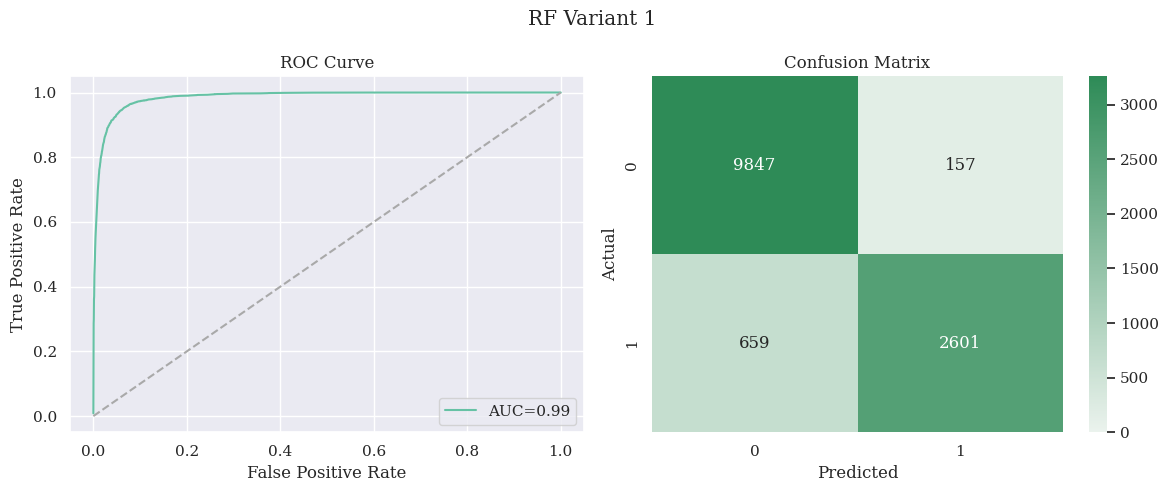

In [ ]:
features_var_1 = X_train.columns
eval_plots(rf_var_1, X_test, y_test, model_name="RF Variant 1")

### RF Model Variant 2: Finding the Best Predictor Subset with Forward Selection
With the feature importance order laid out, we can use this to perform forward feature selection and fit our second model variant. Since importance drops after the first 10 or so features, we'll only consider the top 20 features in the forward selection process to reduce computational cost. For our model selection metric, we'll use 5-fold cross validation accuracy. With such a large dataset, LOOCV or larger values of k would be too computationally expensive. In the forward selection, we'll implement early stopping, so we stop adding features once CV accuracy doesn't show any large improvement.

In [ ]:
# forward selection using importance order
# Warning: This cell takes a while to run!
max_n_features = 20
k = 5
candidate_features = importances.index[:max_n_features]

remaining_features = [f for f in candidate_features]
best_accuracy = 0
best_features = []

for i in tqdm(range(max_n_features)):
  curr_best_feature = None
  curr_accuracy = 0
  for feature in remaining_features:
    candidate_features = best_features + [feature]
    rf_model_2 = RandomForestClassifier(random_state=SEED, n_jobs=-1, max_depth=16)
    rf_model_2.fit(X_train[candidate_features], y_train)
    cv_score = cross_val_score(rf_model_2, X_train[candidate_features], y_train,
                              cv=k, n_jobs=k).mean()

    if cv_score > curr_accuracy:
      curr_accuracy = cv_score
      curr_best_feature = feature
  if curr_accuracy - best_accuracy < 0.001:
    print(f"Early stopping at {i} features.")
    break
  best_accuracy = curr_accuracy
  best_features.append(curr_best_feature)
  remaining_features.remove(curr_best_feature)

 65%|██████▌   | 13/20 [08:37<04:38, 39.82s/it]

Early stopping at 13 features.


After just 13 features, the accuracy stopped improving by more than 0.1%.

In [ ]:
best_features

['f_41_adj_pred',
 'f_48_amplifiers',
 'f_14_nominalizations',
 'f_43_type_token',
 'f_25_present_participle',
 'f_65_clausal_coordination',
 'f_35_because',
 'f_44_mean_word_length',
 'f_20_existential_there',
 'f_16_other_nouns',
 'f_10_demonstrative_pronoun',
 'f_46_downtoners',
 'f_29_that_subj']

In [ ]:
print("Changes in ranking (importance ranking -> forward selection order)")
for i, feature in enumerate(importances.index[:max_n_features]):
  if feature not in best_features:
    continue
  change = i - best_features.index(feature)
  print(f"{readable_features[feature]}: {"+" if change >= 0 else ""}{change}")

Changes in ranking (importance ranking -> forward selection order)
present participle: -4
amplifiers: +0
type token: -1
other nouns: -5
existential there: -1
that subj: -4
downtoners: -2
because: +4
adj pred: +11
demonstrative pronoun: +2
nominalizations: +13
mean word length: +11
clausal coordination: +14


Interestingly, the order of the features is slightly different from the importance order in the maximal model. This could mean features that moved up encode the information contained in all the other features beyond the first 20.

Next, we'll take a look at the bias-variance tradeoff and see how including more features affects our model.

In [ ]:
accuracies = []
num_repeats = 5

for i in tqdm(range(len(best_features))):
  for j in range(num_repeats):
    rf_model = RandomForestClassifier(n_jobs=-1)
    feature_set = best_features[:i+1]
    rf_model.fit(X_train[feature_set], y_train)
    train_acc = rf_model.score(X_train[feature_set], y_train)
    test_acc = rf_model.score(X_test[feature_set], y_test)
    cv_acc = cross_val_score(rf_model, X_train[feature_set], y_train, cv=k).mean()

    accuracies.append({
        "train": train_acc,
        "test": test_acc,
        "cv": cv_acc,
        "n_features": i+1,
        "features": feature_set
    })

accuracies = pd.DataFrame(accuracies)

100%|██████████| 13/13 [04:47<00:00, 22.12s/it]


In [ ]:
best_num_features = accuracies.set_index('n_features')['cv'].idxmax()
best_test_score = accuracies.loc[accuracies['n_features']==best_num_features, 'test'].mean()
best_cv = accuracies.loc[accuracies['n_features']==best_num_features, 'cv'].mean()
print(f"Best number of parameters: {best_num_features}, test score = {round(best_test_score, 2)}")
print(f"Max Model test accuracy: {round(maximal_model_acc, 2)}")

Best number of parameters: 13, test score = 0.93
Max Model test accuracy: 0.94


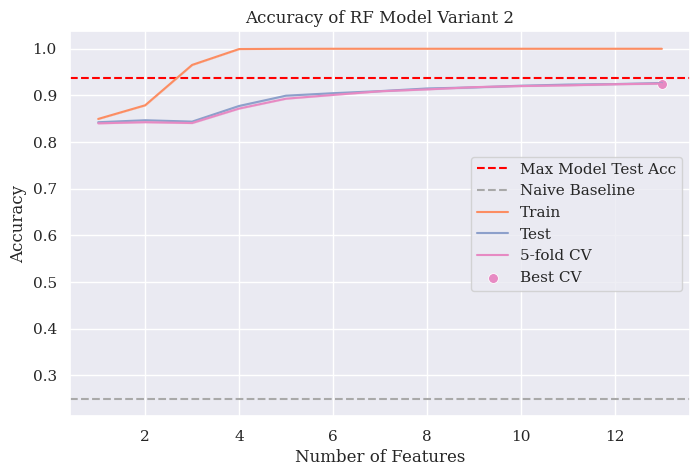

In [ ]:
plt.subplots(figsize=(8, 5))
plt.axhline(maximal_model_acc, linestyle="--", label="Max Model Test Acc", color='red')
plt.axhline(y.mean(), linestyle="--", label="Naive Baseline", color='darkgray')
sns.lineplot(accuracies, x="n_features", y="train", label="Train", color=bias_variance_cmap['train'])
sns.lineplot(accuracies, x="n_features", y="test", label="Test", color=bias_variance_cmap['test'])
sns.lineplot(accuracies, x="n_features", y="cv", label=f"{k}-fold CV", color=bias_variance_cmap['cv'])
sns.scatterplot(x=[best_num_features], y=[best_cv], s=50, color=bias_variance_cmap['cv'], label="Best CV")
plt.title("Accuracy of RF Model Variant 2")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.legend();

With our preliminary analysis, we ordered features by importance in a maximal model, noticing that importance levels off after the top 15 features. Then, we used forward selection to order the top 20 features by how much they improve 5-fold CV accuracy. Finally, we plotted the change in train, test, and CV accuracy to see the interaction with features and the bias-variance tradeoff. Now, we'll train our final second variant with the entirety of the train set, and evaluate it on the test set.

In [ ]:
rf_var_2 = RandomForestClassifier(random_state=SEED, n_jobs=-1, max_depth=16)
best_feature_set = best_features[:best_num_features]
rf_var_2.fit(X_train[best_feature_set], y_train)
rf_var_2.score(X_test[best_feature_set], y_test)

0.9248341375150784

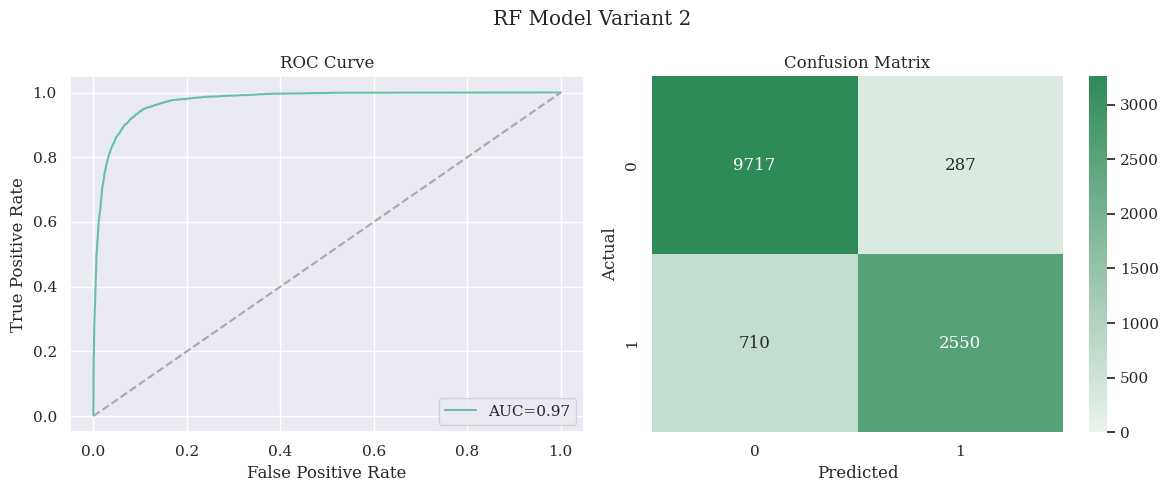

In [ ]:
features_var_2 = best_feature_set
eval_plots(rf_var_2, X_test[best_feature_set], y_test, model_name="RF Model Variant 2")

Judging by the confusion matrix, it seems the smaller model is slightly better at predicting negatives (LLM-generated texts) than the maximal model, but very slightly worse at predicting positives.

### RF Model Variant 3: Tuning Hyperparameters

For our second variant of the Random Forest model, we'll tune hyperparameters such as `n_estimators`, `max_depth`, and `max_features`, checking their effects on performance of the model. We'll analyze the effect of each hyperparameter on train, test, and CV performance for the model, then we'll perform a grid search to find the best combination.

In [ ]:
def plot_hyperparameter_effect(model, hyperparam, values, X_train, y_train, X_test, y_test, k=10):
  metrics = []
  for value in tqdm(values):
    model = model.set_params(**{hyperparam: value, "n_jobs": -1})
    model.fit(X_train, y_train)
    train_metric = model.score(X_train, y_train)
    test_metric = model.score(X_test, y_test)
    cv_metric = cross_val_score(model, X_train, y_train, cv=k, n_jobs=-1).mean()

    metrics.append({
        "value": value,
        "train": train_metric,
        "test": test_metric,
        "cv": cv_metric
    })
  metrics = pd.DataFrame(metrics)
  if any(metrics['value'].apply(type) == str):
    metrics['value'] = metrics['value'].apply(lambda x: str(x))
  sns.lineplot(metrics, x='value', y='train', label='Train', color=bias_variance_cmap['train'])
  sns.lineplot(metrics, x='value', y='test', label='Test', color=bias_variance_cmap['test'])
  sns.lineplot(metrics, x='value', y='cv', label=f'{k}-fold CV', color=bias_variance_cmap['cv'])
  plt.xlabel(hyperparam)
  plt.ylabel("Accuracy")
  plt.title(f"Effect of {hyperparam} on Accuracy")
  cv_best = metrics.set_index('value')['cv'].idxmax()
  test_best = metrics.set_index('value')['test'].idxmax()
  sns.scatterplot(x=[cv_best], y=[metrics.loc[metrics['value']==cv_best, 'cv'].mean()], s=50, color=bias_variance_cmap['cv'])
  sns.scatterplot(x=[test_best], y=[metrics.loc[metrics['value']==test_best, 'test'].mean()], s=50, color=bias_variance_cmap['test'])
  return cv_best, test_best

100%|██████████| 6/6 [01:33<00:00, 15.62s/it]


(np.int64(300), np.int64(150))

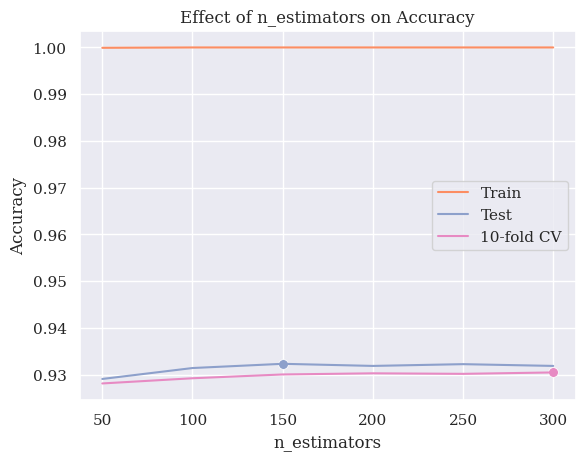

In [ ]:
# n_estimators
model = RandomForestClassifier(random_state=SEED)
hyperparam = 'n_estimators'
values = [50, 100, 150, 200, 250, 300]
plot_hyperparameter_effect(model, hyperparam, values,
                           X_train[best_feature_set], y_train,
                           X_test[best_feature_set], y_test)

100%|██████████| 6/6 [00:30<00:00,  5.14s/it]


(np.int64(32), np.int64(64))

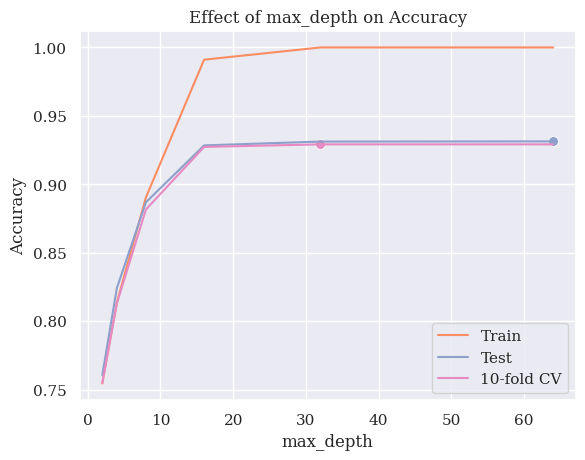

In [ ]:
# max_depth
model = RandomForestClassifier(random_state=SEED)
hyperparam = 'max_depth'
values = [2, 4, 8, 16, 32, 64]
plot_hyperparameter_effect(model, hyperparam, values,
                           X_train[best_feature_set], y_train,
                           X_test[best_feature_set], y_test)

100%|██████████| 7/7 [01:34<00:00, 13.44s/it]


('0.5', '0.5')

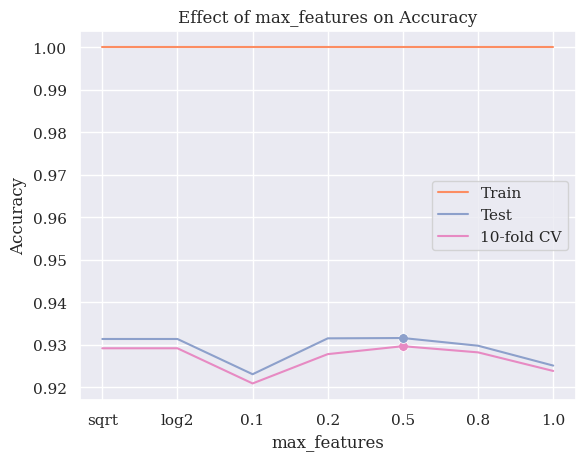

In [ ]:
# max_features
model = RandomForestClassifier(random_state=SEED)
hyperparam = 'max_features'
values = ['sqrt', 'log2', 0.1, 0.2, 0.5, 0.8, 1.0]
plot_hyperparameter_effect(model, hyperparam, values,
                           X_train[best_feature_set], y_train,
                           X_test[best_feature_set], y_test)

100%|██████████| 3/3 [00:30<00:00, 10.08s/it]


('entropy', 'entropy')

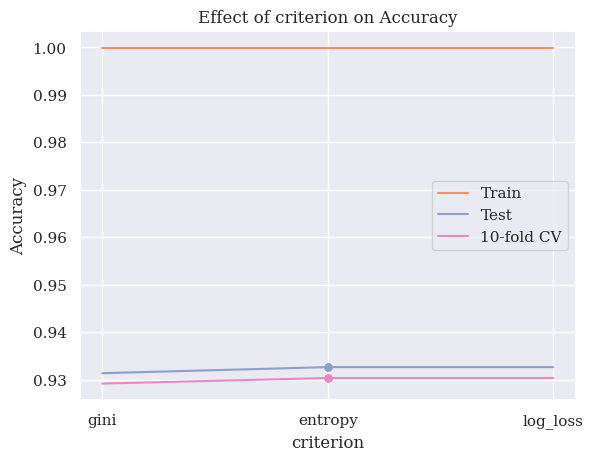

In [ ]:
# criterion
model = RandomForestClassifier(random_state=SEED)
hyperparam = 'criterion'
values = ['gini', 'entropy', 'log_loss']
plot_hyperparameter_effect(model, hyperparam, values,
                           X_train[best_feature_set], y_train,
                           X_test[best_feature_set], y_test)

Looking at the CV accuracy, it seems like both `max_features` was best at middling values, but larger `n_estimators` and `max_depth` achieved better performance. Criterion, on the other hand, had much less impact, but entropy seems like the best choice. We'll use these insights to choose parameters for a grid search, giving `n_estimators` and `max_depth` more room to grow.

In [ ]:
# Grid search initialization
grid = {
    "n_estimators": [250, 300, 350, 400],
    "max_depth": [8, 16, 32, 64],
    "max_features": ["sqrt", "log2", 0.5],
    "criterion": ["entropy"]
}
# 10-fold CV
k=10

gs_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=SEED, criterion='entropy', verbose=1, n_jobs=-1),
    param_grid=grid,
    cv=k,
    n_jobs=-1,
    scoring='accuracy'
)

In [ ]:
# Fit the grid search
gs_rf.fit(X_train[best_feature_set], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    7.2s finished


,estimator,RandomForestC... verbose=1)
,param_grid,"{'criterion': ['entropy'], 'max_depth': [8, 16, ...], 'max_features': ['sqrt', 'log2', ...], 'n_estimators': [250, 300, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,400


In [ ]:
features_var_3 = best_feature_set
rf_var_3 = gs_rf.best_estimator_
rf_var_3.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 32,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 400,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 109,
 'verbose': 1,
 'warm_start': False}

According to the grid search, the best hyperparameters were `max_features=0.5`, `n_estimators=400`, and `max_depth=64`.

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.0s
[Parallel(n_jobs=32)]: Done 400 out of 400 | elapsed:    0.0s finished


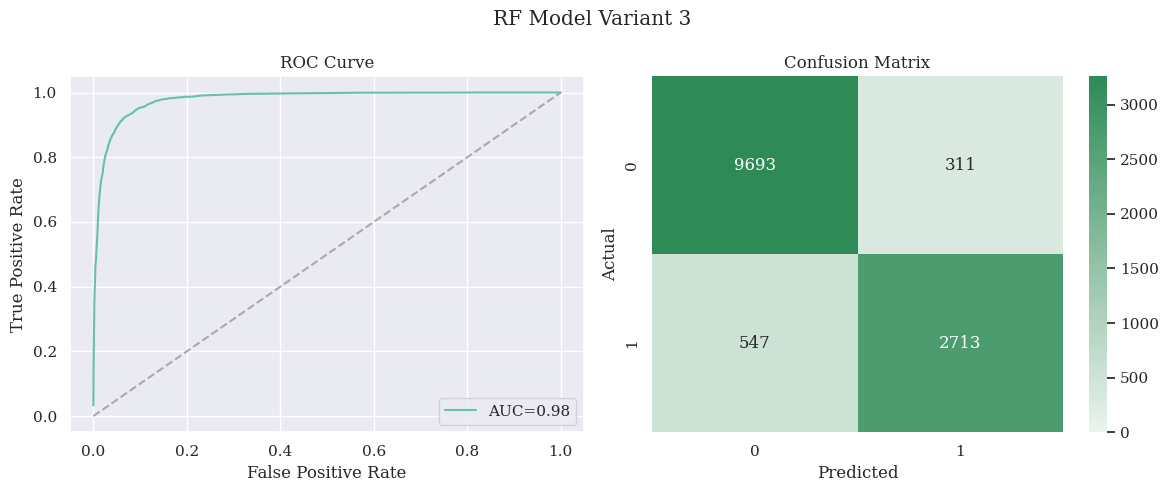

In [ ]:
eval_plots(rf_var_3, X_test[best_feature_set], y_test, model_name="RF Model Variant 3")

### Comparing Variants

Now that we have our variants fit, we can compare each one and see which works the best. We're working with random forest classifiers, which are non-parametric, so we'll use cross-validation to compare each model.

In [ ]:
k = 10
n_repeats = 10
model_variants = {
    "RF Variant 1": [rf_var_1, features_var_1],
    "RF Variant 2": [rf_var_2, features_var_2],
    "RF Variant 3": [rf_var_3, features_var_3],
}

# Calculate k-fold CV for each variant
rf_final_eval = []
for name, variant in model_variants.items():
  model, best_feature_set = variant
  model.set_params(random_state=None)
  for i in range(n_repeats):
    cv_score = cross_val_score(model, X_train[best_feature_set], y_train, cv=k, n_jobs=-1).mean()
    model.fit(X_train[best_feature_set], y_train)
    test_score = model.score(X_test[best_feature_set], y_test)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test[best_feature_set])[:, 1])
    rf_final_eval.append({
        "model_name": name,
        "model": model,
        "features": best_feature_set,
        "cv_score": cv_score,
        "test_score": test_score,
        "roc_auc_score": roc_auc
    })
rf_final_eval = pd.DataFrame(rf_final_eval)

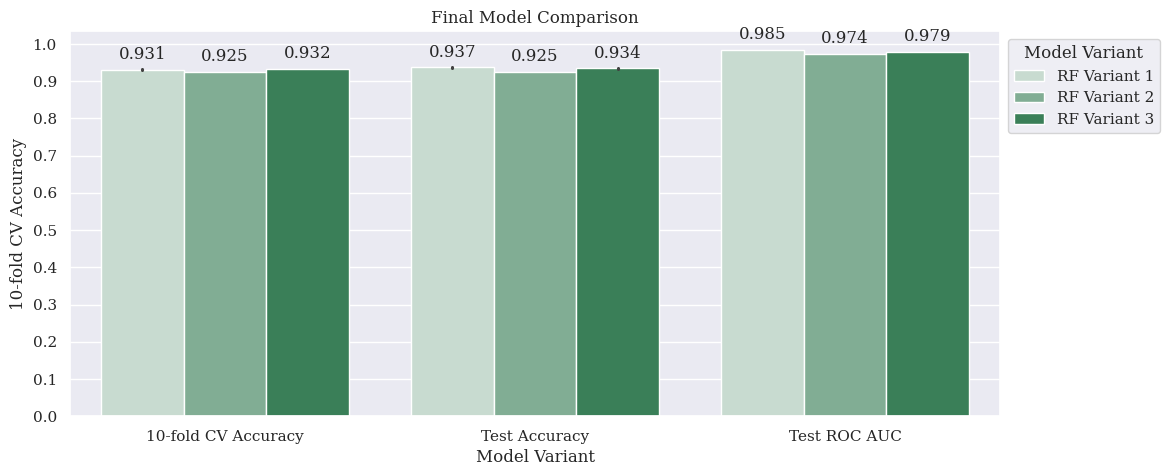

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
melted = pd.melt(rf_final_eval, id_vars=['model_name', 'model', 'features'])
melted['variable'] = melted['variable'].map({
    'cv_score': f'{k}-fold CV Accuracy',
    'test_score': 'Test Accuracy',
    'roc_auc_score': 'Test ROC AUC'
})
sns.barplot(melted, x='variable', y='value', hue='model_name', ax=ax, palette=sns.light_palette('seagreen')[1::2])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.set_title("Final Model Comparison")
ax.set_xlabel("Model Variant")
ax.set_ylabel(f"{k}-fold CV Accuracy")
best_var_cv = rf_final_eval.set_index('model_name')['cv_score'].idxmax()
for container in ax.containers:
      ax.bar_label(container, fmt='%.3f', padding=5)
plt.legend(title="Model Variant", bbox_to_anchor=(1, 1), loc='upper left')

## Logistic Regression Models

We also want to test a logistic regression model because its interpretability will allow us to determine the effects of different predictors. We will fit 3 variants, each with a different subset of predictors.

### Logistic Regression Variant 1: Fitting the Full Model

In [16]:

# fitting a logistic regression model including all predictors
log_reg_full = LogisticRegression(max_iter=1000, random_state=SEED)
log_reg_full.fit(X_train, y_train)

#model predictions
y_train_pred = log_reg_full.predict(X_train)
y_test_pred  = log_reg_full.predict(X_test)

y_test_proba = log_reg_full.predict_proba(X_test)[:, 1]

#metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)
test_auc  = roc_auc_score(y_test, y_test_proba)


print("Full Logistic Regression Model")
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test  Accuracy: {test_acc:.3f}")
print(f"Test ROC AUC:   {test_auc:.3f}")

cv_scores = cross_val_score(
    log_reg_full,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc'
)

print(f"5-Fold CV ROC-AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Full Logistic Regression Model
Train Accuracy: 0.821
Test  Accuracy: 0.828
Test ROC AUC:   0.884
5-Fold CV ROC-AUC: 0.878 ± 0.003


Similar test and train accuracy suggests that the model is not overfitting the data even with all features included. For the next model variant, we'll use backward selection to see if we can improve accuracy by only including features that are most predictive.

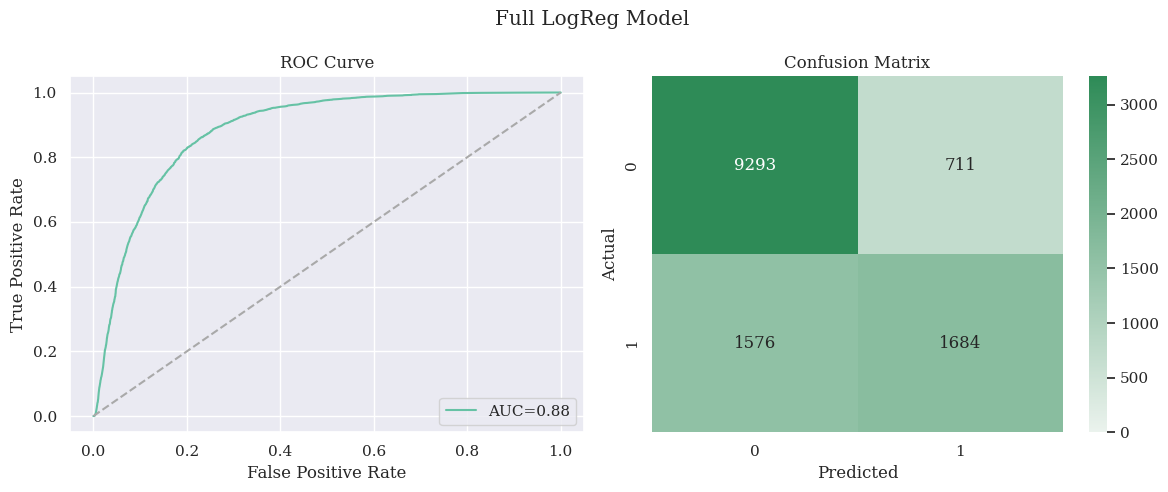

In [22]:
eval_plots(log_reg_full, X_test, y_test, model_name="Full LogReg Model")

The model is performing better than random chance, but there is still room for improvement.
According to this confusion matrix, the model is making more false positive errors -- it is more often predicting that AI-generated text is human than mistaking human text for AI.

### Logistic Regression Variant 2: Backward Selection to Choose Features

In [18]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [29]:
log_reg = LogisticRegression(max_iter=1000, random_state=SEED)
cv = StratifiedKFold(5, shuffle=True, random_state=SEED)

#recursive feature elimination to remove one feature at a time based on cross-validated roc-auc
#use 5-fold cross validationt to test each feature set
rfecv = RFECV(
    estimator=log_reg,
    step=1,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=109, shuffle=True),
      estimator=LogisticRegression(max_iter=1000, random_state=109), n_jobs=-1,
      scoring='roc_auc')

In [30]:
print("Best number of features:", rfecv.n_features_)
selected_features = X_train.columns[rfecv.support_]
print("Selected features:\n", selected_features)

Best number of features: 63
Selected features:
 Index(['f_02_perfect_aspect', 'f_03_present_tense', 'f_04_place_adverbials',
       'f_05_time_adverbials', 'f_06_first_person_pronouns',
       'f_07_second_person_pronouns', 'f_08_third_person_pronouns',
       'f_09_pronoun_it', 'f_10_demonstrative_pronoun',
       'f_11_indefinite_pronouns', 'f_12_proverb_do', 'f_13_wh_question',
       'f_14_nominalizations', 'f_15_gerunds', 'f_16_other_nouns',
       'f_17_agentless_passives', 'f_19_be_main_verb', 'f_21_that_verb_comp',
       'f_22_that_adj_comp', 'f_23_wh_clause', 'f_24_infinitives',
       'f_25_present_participle', 'f_26_past_participle',
       'f_27_past_participle_whiz', 'f_28_present_participle_whiz',
       'f_29_that_subj', 'f_30_that_obj', 'f_31_wh_subj', 'f_32_wh_obj',
       'f_33_pied_piping', 'f_34_sentence_relatives', 'f_35_because',
       'f_36_though', 'f_37_if', 'f_38_other_adv_sub', 'f_39_prepositions',
       'f_40_adj_attr', 'f_41_adj_pred', 'f_42_adverbs', 'f

The model found that 43 of the original linguistic features are most useful for distinguishing human and AI writing. This is a high number of features, so we should be careful to evaluate for overfitting.

In [ ]:
#fit a new model using the selected features
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

log_reg_reduced = LogisticRegression(max_iter=1000, random_state=SEED)
log_reg_reduced.fit(X_train_reduced, y_train)

In [ ]:
#make predictions
y_train_pred_reduced = log_reg_reduced.predict(X_train_reduced)
y_test_pred_reduced = log_reg_reduced.predict(X_test_reduced)

#accuracy scores
train_acc_reduced = accuracy_score(y_train, y_train_pred_reduced)
test_acc_reduced = accuracy_score(y_test, y_test_pred_reduced)

print("Reduced Logistic Regression Model")
print(f"Train Accuracy: {train_acc_reduced:.3f}")
print(f"Test Accuracy:  {test_acc_reduced:.3f}")

Reduced Logistic Regression Model
Train Accuracy: 0.819
Test Accuracy:  0.827


Compared to the full mode, train accuracy decreased slightly while test accuracy increased slightly. While this is an improvement, there is still a large gap between the train and test accuracy, which suggests that overfitting is still an issue. For the next model variant, we should try to increase bias and decrease variance.

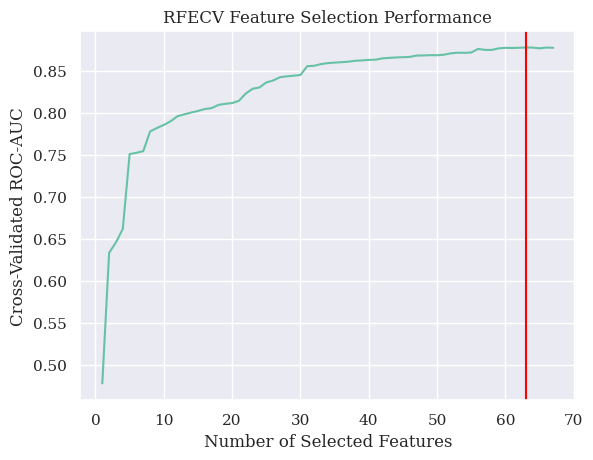

Optimal # of features: 63


In [ ]:
scores = rfecv.cv_results_["mean_test_score"]
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validated ROC-AUC")
plt.title("RFECV Feature Selection Performance")
plt.axvline(x=rfecv.n_features_, color='red')
plt.show()
print("Optimal # of features:", rfecv.n_features_)

In [ ]:
eval_plots(log_reg_reduced, X_test[selected_features], y_test, model_name="Log Reg Variant 2")

Computing 5-fold CV accuracy for each model

### Logistic Regression Variant 3: Ridge Regression

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [25]:
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(
        penalty='l2',
        solver='liblinear',
        max_iter=1000,
        random_state=SEED
    ))
])

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(
    ridge_pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=109,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

In [27]:
best_ridge = grid_ridge.best_estimator_

print("Best C:", grid_ridge.best_params_)
print("Train Accuracy:", best_ridge.score(X_train, y_train))
print("Test Accuracy:", best_ridge.score(X_test, y_test))

from sklearn.metrics import roc_auc_score

ridge_test_auc = roc_auc_score(y_test, best_ridge.predict_proba(X_test)[:, 1])
print("Test ROC-AUC:", ridge_test_auc)


Best C: {'log_reg__C': 100}
Train Accuracy: 0.8226402291917974
Test Accuracy: 0.8302171290711701
Test ROC-AUC: 0.8878049393739436


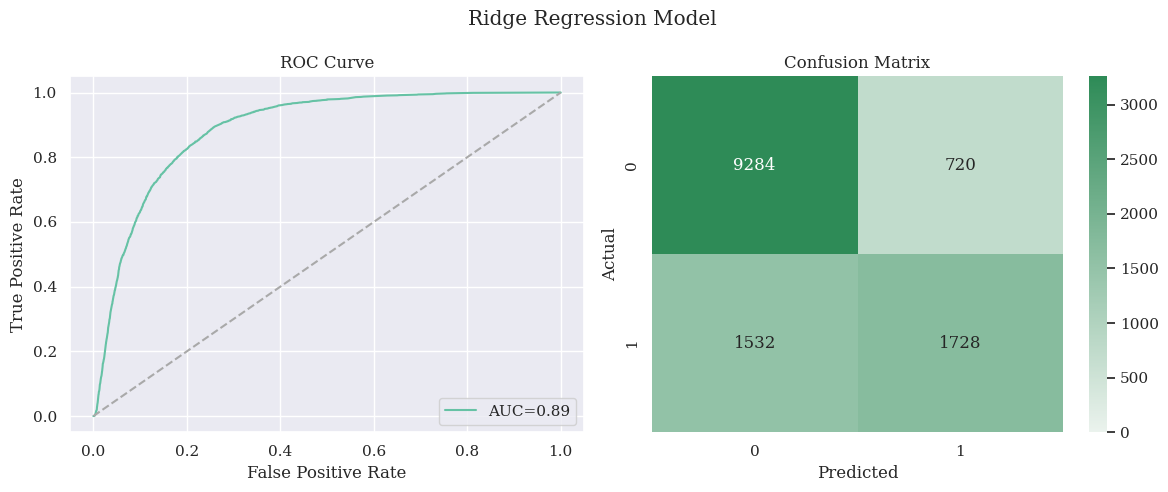

In [28]:
eval_plots(best_ridge, X_test, y_test, model_name="Ridge Regression Model")

### Compare CV ROC-AUC for each of the 3 variants

In [ ]:
from sklearn.model_selection import cross_val_score

k = 5
n_repeats = 5
model_variants = {
    "LogReg Full Model": [log_reg_full, X_train.columns],
    "LogReg Reduced Model": [log_reg_reduced, selected_features]
    "LogReg Ridge Regression Model" : [best_ridge, X_train.columns]
}

#Calculate repeated k-fold CV with ROC-AUC scoring
cv_scores = []
for name, variant in model_variants.items():
    model, best_feature_set = variant
    model.set_params(random_state=None)
    for i in range(n_repeats):
        cv_score = cross_val_score(
            model,
            X_train[best_feature_set],
            y_train,
            cv=k,
            scoring="roc_auc",
            n_jobs=-1
        ).mean()

        cv_scores.append({
            "model_name": name,
            "model": model,
            "features": best_feature_set,
            "cv_score": cv_score
        })

cv_scores = pd.DataFrame(cv_scores)

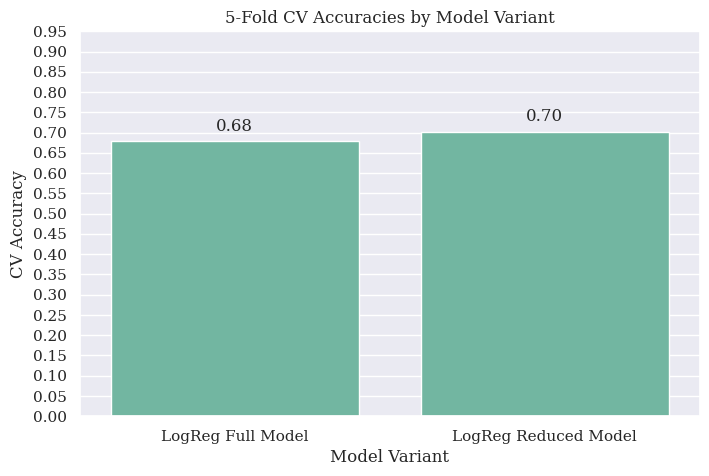

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(cv_scores, x='model_name', y='cv_score', ax=ax)
ax.set_yticks(np.arange(0, 1, 0.05))
ax.set_title("5-Fold CV ROC-AUC by Model Variant")
ax.set_xlabel("Model Variant")
ax.set_ylabel("CV Accuracy")
for container in ax.containers:
      ax.bar_label(container, fmt='%.2f', padding=5);

# References

Biber, D. (1993). Using Register-Diversified Corpora for General Language Studies. Computational Linguistics, 19(2), 219–241. https://aclanthology.org/J93-2001/

Reinhart, A., Markey, B., Laudenbach, M., Pantusen, K., Yurko, R., Weinberg, G., & Brown, D. W. (2025). Do LLMs write like humans? Variation in grammatical and rhetorical styles. Proceedings of the National Academy of Sciences, 122(8). https://doi.org/10.1073/pnas.2422455122